In [1]:
!pip install pyspark dask pandas matplotlib openpyxl

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


Using ECI series: CIU1010000000000A


,SeriesID,Qtr1\n2015,Qtr2\n2015,Qtr3\n2015,Qtr4\n2015,Qtr1\n2016,Qtr2\n2016,Qtr3\n2016
0,CIU1010000000000A,2.6,2.0,2.0,2.0,1.9,2.3,2.3


ECI yearly wage growth (%), Q4 12-month change:


,year,eci_pct_change
0,2015,2.0
1,2016,2.2
2,2017,2.6
3,2018,2.9
4,2019,2.7
5,2020,2.5
6,2021,4.0
7,2022,5.1
8,2023,4.2


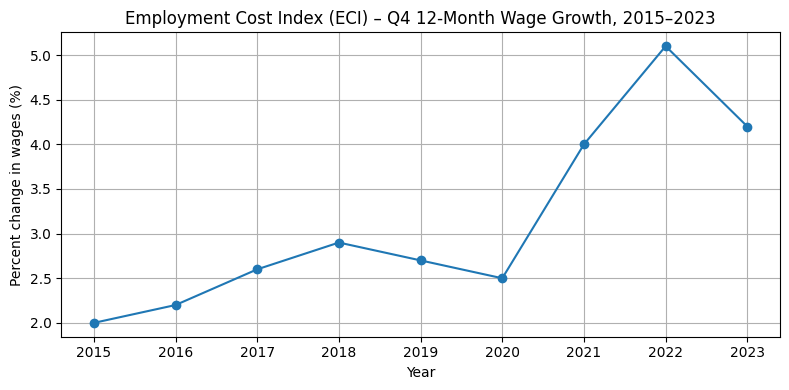

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

ECI_XLSX = "data/ECI.xlsx"

# 1. Read ECI Excel (skip metadata rows so "Series ID / Qtr1\n2015 / ..." are headers)
eci_raw = pd.read_excel(ECI_XLSX, engine="openpyxl", skiprows=3)
eci_raw = eci_raw.dropna(axis=1, how="all")

# 2. Rename first column to SeriesID
first_col_name = eci_raw.columns[0]
eci_raw = eci_raw.rename(columns={first_col_name: "SeriesID"})

# 3. Pick ONE series as your ECI wage-growth series
# (adjust to another Series ID if your assignment specifies a different one)
TARGET_SERIES = "CIU1010000000000A"  # Civilian workers, wages & salaries, 12-month % change
eci_row = eci_raw[eci_raw["SeriesID"] == TARGET_SERIES].copy()

print("Using ECI series:", TARGET_SERIES)
display(eci_row.iloc[:, :8])

# 4. Melt all quarter columns into a long format
eci_long = eci_row.melt(
    id_vars=["SeriesID"],
    var_name="quarter_label",
    value_name="eci_pct_change"
)

# 5. Keep only numeric ECI values
eci_long["eci_pct_change"] = pd.to_numeric(eci_long["eci_pct_change"], errors="coerce")
eci_long = eci_long.dropna(subset=["eci_pct_change"])

# 6. Extract year and quarter from labels like "Qtr4\n2018"
eci_long["year"] = (
    eci_long["quarter_label"]
    .astype(str)
    .str.extract(r"(\d{4})", expand=False)
    .astype(int)
)
eci_long["quarter"] = (
    eci_long["quarter_label"]
    .astype(str)
    .str.extract(r"(Qtr\d)", expand=False)
)

# 7. Use only Q4 values (12-month change at the end of each year)
eci_q4 = eci_long[eci_long["quarter"] == "Qtr4"].copy()

eci_yearly = (
    eci_q4.groupby("year")["eci_pct_change"]
    .mean()
    .reset_index()
    .sort_values("year")
)

print("ECI yearly wage growth (%), Q4 12-month change:")
display(eci_yearly)

# 8. Plot ECI alone
plt.figure(figsize=(8, 4))
plt.plot(eci_yearly["year"], eci_yearly["eci_pct_change"], marker="o", linestyle="-")
plt.title("Employment Cost Index (ECI) – Q4 12-Month Wage Growth, 2015–2023")
plt.xlabel("Year")
plt.ylabel("Percent change in wages (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [70]:
# Save for use in Spark
eci_yearly_path = "data/eci_yearly_q4.csv"
eci_yearly.to_csv(eci_yearly_path, index=False)

In [71]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Big Data Application - ECI_CPI")
    .config("spark.driver.memory", "8g")
    .enableHiveSupport()
    .getOrCreate()
)

eci_yearly_spark = (
    spark.read
    .option("header", "true")
    .option("inferSchema", "true")
    .csv("data/eci_yearly_q4.csv")
)

eci_yearly_spark.createOrReplaceTempView("eci_yearly")

eci_yearly_spark.show()


+----+--------------+
|year|eci_pct_change|
+----+--------------+
|2015|           2.0|
|2016|           2.2|
|2017|           2.6|
|2018|           2.9|
|2019|           2.7|
|2020|           2.5|
|2021|           4.0|
|2022|           5.1|
|2023|           4.2|
+----+--------------+



In [46]:
# === CELL 1: Imports, paths, and target categories ===

import pandas as pd
from collections import OrderedDict

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

DATA_PATH = "data/CLI/"

excel_files = OrderedDict({
    2015: DATA_PATH + "CPI-W_201512.xlsx",
    2016: DATA_PATH + "CPI-W_201612.xlsx",
    2017: DATA_PATH + "cpi-w-201712.xlsx",
    2018: DATA_PATH + "cpi-w-201812.xlsx",
    2019: DATA_PATH + "cpi-w-201912.xlsx",
    2020: DATA_PATH + "cpi-w-202012.xlsx",
    2021: DATA_PATH + "cpi-w-202112.xlsx",
    2022: DATA_PATH + "cpi-w-202212.xlsx",
    2023: DATA_PATH + "cpi-w-202312.xlsx",
})

# Focus on a small interpretable subset of categories
TARGET_CATEGORIES = [
    "All items",
    "All items less food and energy",
    "Food",
    "Energy",
    "Shelter",
    "Medical care services",
    "Transportation services",
]

In [50]:
records = []  # reset, if needed

def normalize(s):
    return str(s).lower().replace("\n", " ").strip()

for year, path in excel_files.items():
    print(f"\nReading {path} for report year {year}...")
    
    df_raw = pd.read_excel(path, engine="openpyxl", header=None)
    
    # find header row with "Indent Level"
    header_row_idx = None
    for i in range(len(df_raw)):
        first_cell = str(df_raw.iloc[i, 0]).strip()
        if first_cell.lower().startswith("indent"):
            header_row_idx = i
            break
    if header_row_idx is None:
        print("  ERROR: no 'Indent Level' row found")
        continue
    
    header = df_raw.iloc[header_row_idx].tolist()
    df = df_raw.iloc[header_row_idx + 1:].copy()
    df.columns = header
    
    print("  Header row index:", header_row_idx)
    print("  First few columns after reheader:", list(df.columns[:8]))
    print("  First 3 data rows:")
    print(df.head(3))

    col_norm = {col: normalize(col) for col in df.columns}

    # --- key columns ---
    # Expenditure category
    exp_col = None
    for col, norm in col_norm.items():
        if "expenditure" in norm and "category" in norm:
            exp_col = col
            break
    if exp_col is None:
        print("  ERROR: no 'Expenditure category' column")
        continue

    # Relative importance
    rel_col = None
    for col, norm in col_norm.items():
        if "relative" in norm and "importance" in norm:
            rel_col = col
            break
    if rel_col is None:
        print(f"  WARNING: no relative-importance column for {year}")
        continue
    print(f"  Using relative-importance column: {rel_col!r}")

    # Annual % change – use the FIRST "Unadjusted percent change" column by position
    annual_idx = None
    for j, col in enumerate(df.columns):
        if "unadjusted percent change" in normalize(col):
            annual_idx = j
            break
    if annual_idx is None:
        print(f"  WARNING: no 'Unadjusted percent change' column for {year}")
        continue
    print(f"  Using annual percent-change column index: {annual_idx} (name: {df.columns[annual_idx]!r})")

    # --- grab rows for each category (no indent filter now) ---
    for cat in TARGET_CATEGORIES:
        mask = df[exp_col].astype(str).str.strip() == cat
        row = df[mask]
        if row.empty:
            print(f"    NOTE: Category '{cat}' not found for {year}, skipping.")
            continue

        r = row.iloc[0]  # single row Series

        rel_val = pd.to_numeric(r[rel_col], errors="coerce")
        ann_val = pd.to_numeric(r.iloc[annual_idx], errors="coerce")  # use positional index

        records.append({
            "year": int(year),
            "category": cat,
            "relative_importance": rel_val,
            "annual_inflation_pct": ann_val,
        })

# build final table
cpi_cat_year_pd = pd.DataFrame.from_records(records)

print("\n=== CPI category-by-year features (pandas) ===")
print(cpi_cat_year_pd.head(20))
print("\nShape:", cpi_cat_year_pd.shape)
print("\nUnique years:", sorted(cpi_cat_year_pd['year'].unique()) if not cpi_cat_year_pd.empty else "[]")
print("Categories:", cpi_cat_year_pd['category'].unique() if not cpi_cat_year_pd.empty else "[]")



Reading data/CLI/CPI-W_201512.xlsx for report year 2015...
  Header row index: 3
  First few columns after reheader: ['Indent Level', 'Expenditure category', 'Relative\nimportance\nNov.\n2015', 'Unadjusted indexes', nan, nan, nan, nan]
  First 3 data rows:
  Indent Level Expenditure category Relative\nimportance\nNov.\n2015  \
4          NaN                  NaN                              NaN   
5          NaN                  NaN                              NaN   
6            0            All items                              100   

  Unadjusted indexes         NaN         NaN         NaN         NaN  \
4         Dec.\n2014  Jan.\n2015  Feb.\n2015  Mar.\n2015  Apr.\n2015   
5                NaN         NaN         NaN         NaN         NaN   
6            229.909     228.294     229.421     231.055      231.52   

         NaN         NaN  ...         NaN         NaN         NaN  \
4  May\n2015  Jun.\n2015  ...  Oct.\n2015  Nov.\n2015  Dec.\n2015   
5        NaN         NaN  

In [52]:
import pandas as pd

# Clean types once
cpi_cat_year_pd["year"] = cpi_cat_year_pd["year"].astype(int)
cpi_cat_year_pd["annual_inflation_pct"] = (
    cpi_cat_year_pd["annual_inflation_pct"].astype(float)
)

# Save to CSV instead of parquet
out_path = "data/CLI/cpi_category_inflation_2015_2023.csv"
cpi_cat_year_pd.to_csv(out_path, index=False)
print("Wrote:", out_path)

# Quick peek
print(cpi_cat_year_pd.head())


Wrote: data/CLI/cpi_category_inflation_2015_2023.csv
   year                        category  relative_importance  \
0  2015                       All items              100.000   
1  2015  All items less food and energy               76.194   
2  2015                            Food               15.066   
3  2015                          Energy                8.740   
4  2015                         Shelter               31.787   

   annual_inflation_pct  
0                   0.4  
1                   2.1  
2                   0.7  
3                 -13.0  
4                   3.2  


In [53]:
cpi_cat_year_spark = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv("data/CLI/cpi_category_inflation_2015_2023.csv")
)
cpi_cat_year_spark.show(10)


+----+--------------------+-------------------+--------------------+
|year|            category|relative_importance|annual_inflation_pct|
+----+--------------------+-------------------+--------------------+
|2015|           All items|              100.0|                 0.4|
|2015|All items less fo...|             76.194|                 2.1|
|2015|                Food|             15.066|                 0.7|
|2015|              Energy|               8.74|               -13.0|
|2015|             Shelter|             31.787|                 3.2|
|2015|Medical care serv...|              4.993|                 3.0|
|2015|Transportation se...|              5.933|                 3.4|
|2016|           All items|              100.0|                 2.0|
|2016|All items less fo...|             76.492|                 2.1|
|2016|                Food|             14.984|                -0.4|
+----+--------------------+-------------------+--------------------+
only showing top 10 rows



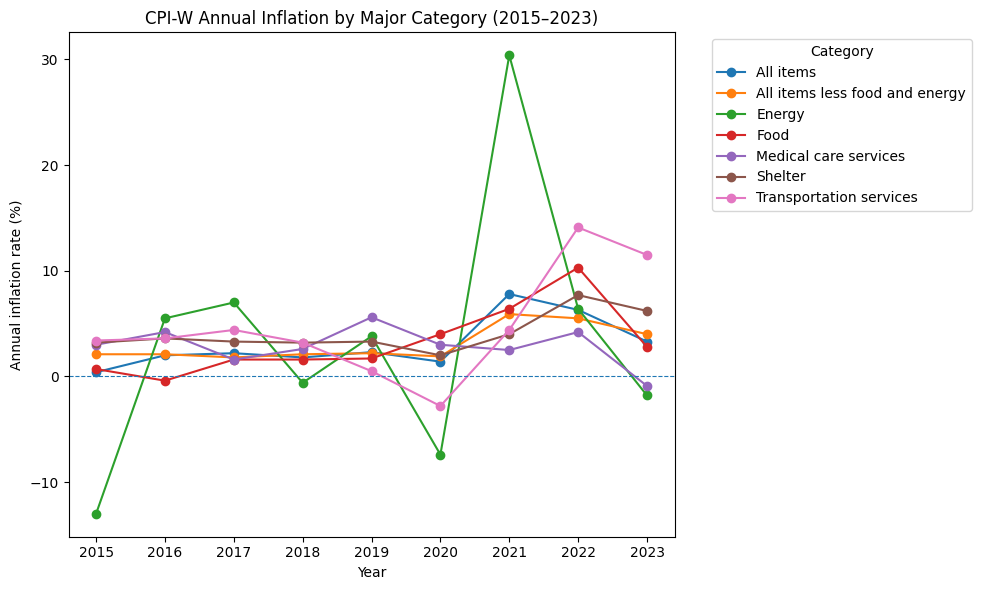

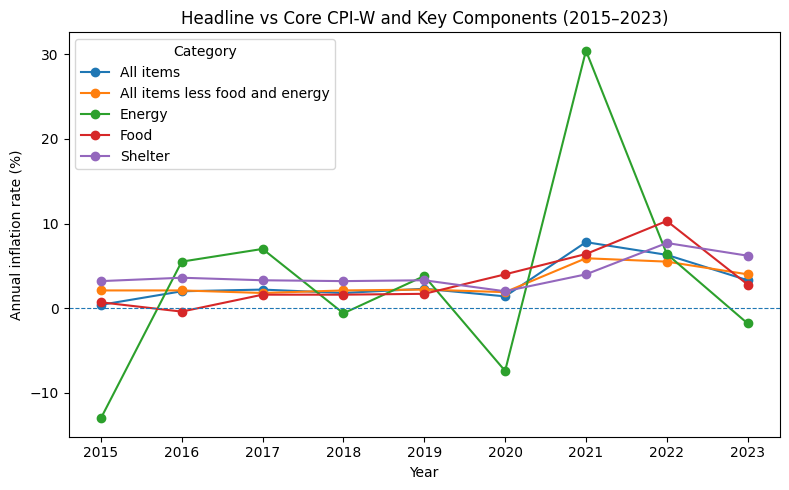

category,All items,All items less food and energy,Energy,Food,Medical care services,Shelter,Transportation services
year,,,,,,,
2015,0.4,2.1,-13.0,0.7,3.0,3.2,3.4
2016,2.0,2.1,5.5,-0.4,4.2,3.6,3.6
2017,2.2,1.8,7.0,1.6,1.6,3.3,4.4
2018,1.8,2.1,-0.6,1.6,2.6,3.2,3.2
2019,2.3,2.2,3.8,1.7,5.6,3.3,0.5
2020,1.4,1.9,-7.4,4.0,3.0,2.0,-2.8
2021,7.8,5.9,30.4,6.4,2.5,4.0,4.4
2022,6.3,5.5,6.4,10.3,4.2,7.7,14.1
2023,3.3,4.0,-1.8,2.8,-0.9,6.2,11.5


In [54]:
import matplotlib.pyplot as plt

# Ensure sorted for plots
plot_df = cpi_cat_year_pd.sort_values(["year", "category"])

# Pivot: rows = year, columns = category, values = annual inflation %
pivot = plot_df.pivot_table(
    index="year",
    columns="category",
    values="annual_inflation_pct"
)

# ---------- 1) Full multi-category trend ----------
plt.figure(figsize=(10, 6))

for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker="o", label=col)

plt.axhline(0, linestyle="--", linewidth=0.8)
plt.title("CPI-W Annual Inflation by Major Category (2015–2023)")
plt.xlabel("Year")
plt.ylabel("Annual inflation rate (%)")
plt.xticks(pivot.index)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ---------- 2) Focused: headline vs core + key components ----------
plt.figure(figsize=(8, 5))

focus_cols = [
    "All items",
    "All items less food and energy",
    "Energy",
    "Food",
    "Shelter",
]

for col in focus_cols:
    if col in pivot.columns:
        plt.plot(pivot.index, pivot[col], marker="o", label=col)

plt.axhline(0, linestyle="--", linewidth=0.8)
plt.title("Headline vs Core CPI-W and Key Components (2015–2023)")
plt.xlabel("Year")
plt.ylabel("Annual inflation rate (%)")
plt.xticks(pivot.index)
plt.legend(title="Category")
plt.tight_layout()
plt.show()

pivot  # nice to see the table too


CPI-W All-items inflation (%):


,year,cpi_inflation_pct
0,2015,0.4
7,2016,2.0
14,2017,2.2
21,2018,1.8
28,2019,2.3
35,2020,1.4
42,2021,7.8
49,2022,6.3
56,2023,3.3


Combined ECI + CPI-W (All items):


,year,eci_pct_change,cpi_inflation_pct,real_wage_growth
0,2015,2.0,0.4,1.6
1,2016,2.2,2.0,0.2
2,2017,2.6,2.2,0.4
3,2018,2.9,1.8,1.1
4,2019,2.7,2.3,0.4
5,2020,2.5,1.4,1.1
6,2021,4.0,7.8,-3.8
7,2022,5.1,6.3,-1.2
8,2023,4.2,3.3,0.9


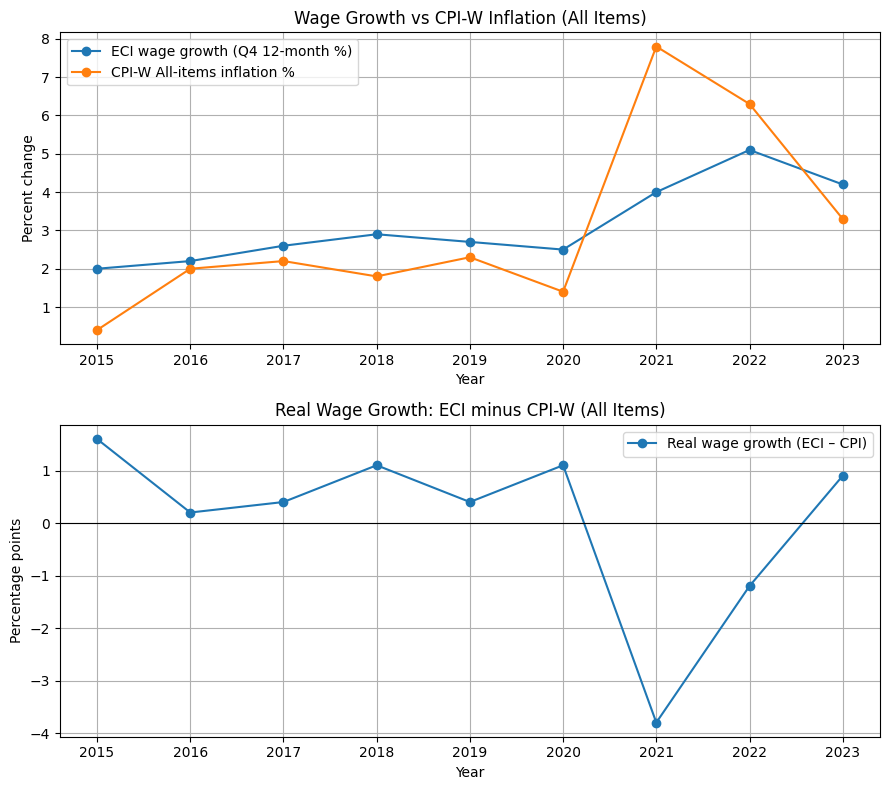

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Grab CPI "All items" from your existing CLI result ---

# If your DataFrame is called cpi_cat_year instead, change this line.
cpi_source = cpi_cat_year_pd  

cpi_all = (
    cpi_source[cpi_source["category"] == "All items"]
    [["year", "annual_inflation_pct"]]
    .rename(columns={"annual_inflation_pct": "cpi_inflation_pct"})
    .sort_values("year")
)

print("CPI-W All-items inflation (%):")
display(cpi_all)

# --- 2. Merge ECI (eci_yearly) and CPI (cpi_all) on year ---

combined = (
    eci_yearly.merge(cpi_all, on="year", how="inner")
    .sort_values("year")
    .reset_index(drop=True)
)

# Real wage growth = nominal wage growth – inflation
combined["real_wage_growth"] = (
    combined["eci_pct_change"] - combined["cpi_inflation_pct"]
)

print("Combined ECI + CPI-W (All items):")
display(combined)

# --- 3. Plot: nominal wage growth vs inflation, and real wage growth ---

plt.figure(figsize=(9, 8))

# Top subplot: ECI wage growth vs CPI inflation
plt.subplot(2, 1, 1)
plt.plot(
    combined["year"], combined["eci_pct_change"],
    marker="o", label="ECI wage growth (Q4 12-month %)"
)
plt.plot(
    combined["year"], combined["cpi_inflation_pct"],
    marker="o", label="CPI-W All-items inflation %"
)
plt.title("Wage Growth vs CPI-W Inflation (All Items)")
plt.xlabel("Year")
plt.ylabel("Percent change")
plt.grid(True)
plt.legend()

# Bottom subplot: real wage growth
plt.subplot(2, 1, 2)
plt.plot(
    combined["year"], combined["real_wage_growth"],
    marker="o", label="Real wage growth (ECI – CPI)"
)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Real Wage Growth: ECI minus CPI-W (All Items)")
plt.xlabel("Year")
plt.ylabel("Percentage points")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
